In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "C://Users//marco//Downloads//IMC-Prosperity-2025-Rice//72ef7f15-aea6-4d03-9af9-6c05c710c932.csv"
df = pd.read_csv(file_path, delimiter=';')

In [8]:
def weighted_midprice(df, levels=1, quantity_power = 1):
    def calculate_weighted_midprice(row, levels, quantity_power):
        bid_side = []
        ask_side = []
        
        for level in range(1, levels + 1):
            bid_price = row.get(f'bid_price_{level}', np.nan)
            bid_volume = row.get(f'bid_volume_{level}', np.nan) ** quantity_power
            ask_price = row.get(f'ask_price_{level}', np.nan)
            ask_volume = row.get(f'ask_volume_{level}', np.nan) ** quantity_power
            
            if np.isfinite(bid_price) and np.isfinite(bid_volume) and bid_volume > 0:
                bid_side.append((bid_price, bid_volume))
            if np.isfinite(ask_price) and np.isfinite(ask_volume) and ask_volume > 0:
                ask_side.append((ask_price, ask_volume))
        
        if not bid_side or not ask_side:
            return np.nan
        
        total_bid_weight = sum(volume for _, volume in bid_side)
        total_ask_weight = sum(volume for _, volume in ask_side)
        
        weighted_bid_price = sum(price * volume for price, volume in bid_side) / total_bid_weight if total_bid_weight > 0 else np.nan
        weighted_ask_price = sum(price * volume for price, volume in ask_side) / total_ask_weight if total_ask_weight > 0 else np.nan
        
        return (weighted_bid_price + weighted_ask_price) / 2 if np.isfinite(weighted_bid_price) and np.isfinite(weighted_ask_price) else np.nan
    
    return df.apply(lambda row: calculate_weighted_midprice(row, levels, quantity_power), axis=1)

df['weighted_midprice_level_1'] = weighted_midprice(df, levels=1, quantity_power = 1)
df['weighted_midprice_level_2'] = weighted_midprice(df, levels=2, quantity_power = 1)
df['weighted_midprice_level_3'] = weighted_midprice(df, levels=3, quantity_power = 1)

df['log_return_l1'] = df.groupby('product')['weighted_midprice_level_1'].transform(lambda x: np.log(x / x.shift()).fillna(0))
df['log_return_l2'] = df.groupby('product')['weighted_midprice_level_2'].transform(lambda x: np.log(x / x.shift()).fillna(0))
df['log_return_l3'] = df.groupby('product')['weighted_midprice_level_3'].transform(lambda x: np.log(x / x.shift()).fillna(0))

lags_realized_vol = [5, 10, 20]

for lag in lags_realized_vol:
    df[f'realized_vol_lag_{lag}'] = df.groupby('product')['log_return_l1'].transform(lambda x: x.pow(2).rolling(window=lag, min_periods=lag).mean().pow(0.5))

display(df.head())


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,profit_and_loss,weighted_midprice_level_1,weighted_midprice_level_2,weighted_midprice_level_3,log_return_l1,log_return_l2,log_return_l3,realized_vol_lag_5,realized_vol_lag_10,realized_vol_lag_20
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,...,0.0,10003.0,10001.467742,10000.108367,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,...,0.0,2028.5,2027.833333,2027.078125,0.000000,0.000000,0.000000,NaN,NaN,NaN
2,-1,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,...,0.0,2026.5,2026.958333,2026.958333,-0.000986,-0.000432,-0.000059,NaN,NaN,NaN
3,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,...,0.0,10000.0,10000.000000,10000.000000,-0.000300,-0.000147,-0.000011,NaN,NaN,NaN
4,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,...,0.0,10000.0,10000.000000,10000.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN


In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def har_all_features(X, lags, window_y=1):
    df = pd.DataFrame(X.T)
    
    # Calculate lag features (unchanged from your original code)
    lag_features = np.zeros((df.shape[0], len(lags) * df.shape[1]))
    for i, lag in enumerate(lags):
        start_ind = i * df.shape[1]
        end_ind = (i + 1) * df.shape[1]
        if i == 0:
            lag_features[:, start_ind : end_ind] = df.rolling(lag).mean().shift(1).to_numpy()
        else:
            prev_lag = lags[i-1]  # Previous lag boundary
            lag_features[:, start_ind:end_ind] = (
                df.rolling(lag).sum().shift(1).to_numpy() - df.rolling(prev_lag).sum().shift(1).to_numpy()
            ) / (lag - prev_lag)
    
    # For features_y, calculate forward-looking averages
    features_y = np.zeros_like(df.values)
    for i in range(len(df) - window_y + 1):
        # For each eligible row, compute average of current and next window_y-1 values
        features_y[i] = df.iloc[i:i+window_y].mean().values
    
    # Set valid range accounting for both lags and forward window
    start_idx = max(lags)
    end_idx = len(df) - window_y + 1
    
    # Return only the valid range
    return lag_features[start_idx:end_idx], features_y[start_idx:end_idx]


# betas = {}

# signal_return_correlation = {}
# for product in df['product'].unique():

#     X, y = har_all_features(df[df['product'] == product]['log_return_l1'], lags=[i for i in range(1, 2)], window_y=1)

#     model = sm.OLS(y, X).fit()

    # fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # plot_acf(y, ax=axes[0], lags=20)
    # plot_pacf(y, ax=axes[1], lags=20)
    # plt.show()
    # print(model.summary())
    # print(model.rsquared)
    # y_pred = model.predict(X)

    # plt.scatter(y, y_pred, label = product)
    # plt.legend()
    # plt.show()
    # betas[product] = model.params
    # signal_return_correlation[product] = model.rsquared ** 0.5

# print(betas)
# print(signal_return_correlation)


In [44]:
!pip install pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   --------------------------------------- 614.7/614.7 kB 11.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------------ --------- 2.1/2.8 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 10.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Users\marco\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs

arima_betas = {}
arima_signal_return_correlation = {}
for product in df['product'].unique():

    X, y = har_all_features(df[df['product'] == product]['log_return_l1'], lags=[i for i in range(1, 2)], window_y=1)

    model1 = ARIMA(y, order=(0, 0, 1))  # Adjust d based on stationarity tests
    result1 = model1.fit()
    print(result1.summary())
    # After fitting your model
    y_pred = result1.predict()
    y_mean = y.mean()
    ss_total = sum((y - y_mean) ** 2)
    ss_residual = sum(result1.resid ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    print(f"R-squared: {r_squared}")


    ar_params = np.array(result1.arparams)
    ma_params = np.array(result1.maparams)

    arima_betas[product] = (ar_params, ma_params)
    
    arima_signal_return_correlation[product] = r_squared ** 0.5

print(arima_betas)
print(arima_signal_return_correlation)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1999
Model:                 ARIMA(0, 0, 1)   Log Likelihood               14646.057
Date:                Mon, 10 Mar 2025   AIC                         -29286.113
Time:                        12:38:30   BIC                         -29269.312
Sample:                             0   HQIC                        -29279.944
                               - 1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.673e-06   9.45e-07     -1.770      0.077   -3.52e-06    1.79e-07
ma.L1         -0.7518      0.021    -35.938      0.000      -0.793      -0.711
sigma2      2.684e-08   8.31e-10     32.301      0.0

C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Calculate historical vol
- Add theo columnm which is the true mid price using weighted average using tightest spread and quantity fraction
- Add rolling average of mid prices (window_size=5)
- Add a vol column where we calculate vol based on last 5 entries

In [14]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
import statsmodels.api as sm

def parse_trading_log(log_file_path: str) -> pd.DataFrame:
    """
    Parse a trading log file and extract metrics into a DataFrame.
    
    Args:
        log_file_path: Path to the log file
        
    Returns:
        DataFrame containing parsed data with columns:
        - Timestamp
        - Symbol
        - TheoreticalPrice
        - ExpectedReturn
        - RealizedReturn
        - FillPercentage
    """
    # Read the log file
    with open(log_file_path, 'r') as file:
        log_content = file.read()
    
    # Define regex patterns for extracting data
    theo_price_pattern = r"Theoretical Price at timestamp (\d+) for ([A-Z_]+): ([0-9.]+)"
    expected_return_pattern = r"Expected Return at timestamp (\d+): {.*?'([A-Z_]+)':\s*([^,}]+).*?'([A-Z_]+)':\s*([^,}]+)"
    realized_return_pattern = r"Realized Return at timestamp (\d+): {.*?'([A-Z_]+)':\s*([^,}]+).*?'([A-Z_]+)':\s*([^,}]+)"
    fill_pattern = r"\[(\d+)\]\[([A-Z_]+)\] Maker Fill %: ([0-9.]+)%, Taker Fill %: ([0-9.]+)%"

    # Extract data using regex
    theo_prices = []
    for match in re.finditer(theo_price_pattern, log_content):
        timestamp, symbol, price = match.groups()
        theo_prices.append({
            'Timestamp': int(timestamp),
            'Symbol': symbol,
            'TheoreticalPrice': float(price)
        })
    
    expected_returns = []
    for match in re.finditer(expected_return_pattern, log_content):
        timestamp, symbol1, value1, symbol2, value2 = match.groups()
        
        # Handle various formats (numeric, lists, etc.)
        try:
            value1 = float(value1) if not value1.startswith('[') else 0.0
            value2 = float(value2) if not value2.startswith('[') else 0.0
        except ValueError:
            value1 = 0.0
            value2 = 0.0
            
        expected_returns.append({
            'Timestamp': int(timestamp),
            'Symbol': symbol1,
            'ExpectedReturn': value1
        })
        expected_returns.append({
            'Timestamp': int(timestamp),
            'Symbol': symbol2,
            'ExpectedReturn': value2
        })
    
    realized_returns = []
    for match in re.finditer(realized_return_pattern, log_content):
        timestamp, symbol1, value1, symbol2, value2 = match.groups()
        realized_returns.append({
            'Timestamp': int(timestamp),
            'Symbol': symbol1,
            'RealizedReturn': float(value1)
        })
        realized_returns.append({
            'Timestamp': int(timestamp),
            'Symbol': symbol2,
            'RealizedReturn': float(value2)
        })
    
    fill_percentages = []
    for match in re.finditer(fill_pattern, log_content):
        timestamp, symbol, maker_percentage, taker_percentage = match.groups()
        fill_percentages.append({
            'Timestamp': int(timestamp),
            'Symbol': symbol,
            'MakerFillPercentage': float(maker_percentage),
            'TakerFillPercentage': float(taker_percentage)
        })
    
    # Convert to DataFrames
    df_theo = pd.DataFrame(theo_prices)
    df_expected = pd.DataFrame(expected_returns)
    df_realized = pd.DataFrame(realized_returns)
    df_fill = pd.DataFrame(fill_percentages)
    
    # Merge all DataFrames on Timestamp and Symbol
    result = df_theo.merge(df_expected, on=['Timestamp', 'Symbol'], how='outer')
    result = result.merge(df_realized, on=['Timestamp', 'Symbol'], how='outer')
    result = result.merge(df_fill, on=['Timestamp', 'Symbol'], how='outer')
    
    # Sort and clean up
    result.sort_values(['Timestamp', 'Symbol'], inplace=True)
    result.reset_index(drop=True, inplace=True)
    
    return result

def analyze_trading_log(log_df: pd.DataFrame) -> Dict:
    """
    Analyze trading log data to produce summary statistics and correlations.
    
    Args:
        log_df: DataFrame created by parse_trading_log
        
    Returns:
        Dictionary containing analysis results
    """
    results = {}
    symbols = log_df['Symbol'].unique()
    
    # Overall statistics
    results['total_timestamps'] = log_df['Timestamp'].nunique()
    results['symbols'] = list(symbols)
    
    # Statistics per symbol
    symbol_stats = {}
    
    for symbol in symbols:
        symbol_data = log_df[log_df['Symbol'] == symbol]
        
        # Calculate mean fill percentage
        avg_maker_fill = symbol_data['MakerFillPercentage'].mean()
        avg_taker_fill = symbol_data['TakerFillPercentage'].mean()
        
        # Get non-zero expected returns for correlation
        valid_data = symbol_data.dropna(subset=['ExpectedReturn', 'RealizedReturn'])
        
        # Calculate correlation if we have enough data points
        if len(valid_data) >= 5:
            correlation = valid_data['ExpectedReturn'].corr(valid_data['RealizedReturn'])
        else:
            correlation = np.nan
        
        # Store statistics
        symbol_stats[symbol] = {
            'average_maker_fill_percentage': avg_maker_fill,
            'average_taker_fill_percentage': avg_taker_fill,
            'count': len(symbol_data),
            'correlation_expected_vs_realized': correlation,
        }
    
    results['symbol_stats'] = symbol_stats
    return results

# Parse the log
log_df = parse_trading_log("C://Users//marco\Downloads//992e71b1-b995-4cd4-99cb-b887f779ec38.log")

results = analyze_trading_log(log_df)


In [17]:
symbol_mask = log_df['Symbol'] == 'RAINFOREST_RESIN'


display(log_df[symbol_mask].head())

,Timestamp,Symbol,TheoreticalPrice,ExpectedReturn,RealizedReturn,MakerFillPercentage,TakerFillPercentage
1,0,RAINFOREST_RESIN,10002.666667,0.000000,0.000000,0.0,0.0
3,100,RAINFOREST_RESIN,10000.000000,0.000000,-0.000267,0.0,0.0
5,200,RAINFOREST_RESIN,10000.000000,-0.000011,0.000000,0.0,0.0
7,300,RAINFOREST_RESIN,10000.000000,0.000000,0.000000,0.0,0.0
9,400,RAINFOREST_RESIN,10000.000000,0.000000,0.000000,0.0,0.0


                                 OLS Regression Results                                
Dep. Variable:         RealizedReturn   R-squared (uncentered):                   0.248
Model:                            OLS   Adj. R-squared (uncentered):              0.247
Method:                 Least Squares   F-statistic:                              658.3
Date:                Mon, 10 Mar 2025   Prob (F-statistic):                   9.76e-126
Time:                        12:43:36   Log-Likelihood:                          14168.
No. Observations:                2000   AIC:                                 -2.833e+04
Df Residuals:                    1999   BIC:                                 -2.833e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

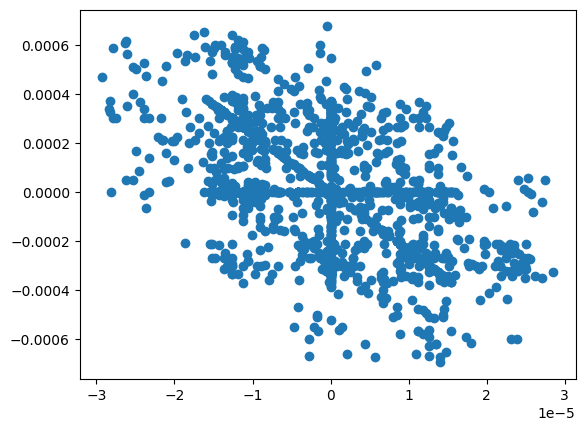

In [18]:

symbol_mask = log_df['Symbol'] == 'RAINFOREST_RESIN'


model = sm.OLS(log_df[symbol_mask]['RealizedReturn'], log_df[symbol_mask]['ExpectedReturn'])
result = model.fit()
print(result.summary())

plt.scatter(log_df[symbol_mask]['ExpectedReturn'], log_df[symbol_mask]['RealizedReturn'])

plt.show()



### Summary of PNL Per Product / Strategy

### Multiple Theos - Effect of Bid-Ask Bounce

### Execution Probability of Maker Orders Given Width

### Volatility Regression

### Forecasting Future Price Given Fills And Past Returns

### Lead / Lag Relationships

### Cross-Product Correlations

### Multi-Period Forecasting